In [26]:
from datetime import date

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import tweepy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from secrets import CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_SECRET

seaborn.set()

In [4]:
NEWS_ORGS = {
    "BBC": "@BBC",
    "CBS": "@CBS",
    "FOX": "@FoxNews",
    "NYT": "@nytimes",
}

In [5]:
def get_api(consumer_key, consumer_secret, access_token, access_secret):
    """Returns a handle on the Twitter API, provided by Tweepy"""
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    return tweepy.API(auth)

In [6]:
api = get_api(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_SECRET)

In [7]:
def get_recent_tweets(api, orgs, count=100):
    """Downloads the 'count' most recent tweets from each org.

    api: twitter API handle, provided by Tweepy
    orgs: dictionary of {org name: twitter handle}
    count: number of tweets per org to get
    Returns a dictionary of {org name: [statuses...]}
    """
    results = {}
    for org, handle in orgs.items():
        most_recent_statuses = api.user_timeline(handle, count=100)
        results[org] = most_recent_statuses
    return results

In [8]:
recents = get_recent_tweets(api, NEWS_ORGS)

In [9]:
dir(recents["BBC"][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_api',
 '_json',
 'author',
 'contributors',
 'coordinates',
 'created_at',
 'destroy',
 'entities',
 'favorite',
 'favorite_count',
 'favorited',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'parse',
 'parse_list',
 'place',
 'possibly_sensitive',
 'retweet',
 'retweet_count',
 'retweeted',
 'retweets',
 'source',
 'source_url',
 'text',
 'truncated',
 'user']

In [10]:
this_tweet = recents["BBC"][0]
print(type(this_tweet.created_at))
this_tweet.created_at.date()

<class 'datetime.datetime'>


datetime.date(2018, 4, 5)

In [11]:
def analyze_tweets(tweets):
    """Analyze polarity sentiments of tweets.
    tweets: a list of Tweepy Status objects.
    Returns: a list of VADER polarity scores of the form
             {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
    """
    texts = [tweet.text for tweet in tweets]
    analyzer = SentimentIntensityAnalyzer()
    return [analyzer.polarity_scores(text) for text in texts]

In [12]:
org_sentiments = {org: analyze_tweets(tweets) for (org, tweets) in recents.items()}
org_sentiments["BBC"][:5]

[{'compound': -0.6908, 'neg': 0.217, 'neu': 0.783, 'pos': 0.0},
 {'compound': 0.7096, 'neg': 0.0, 'neu': 0.629, 'pos': 0.371},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': -0.765, 'neg': 0.32, 'neu': 0.68, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}]

In [13]:
df_data = []
for org, tweets in recents.items():
    for ind, tweet in enumerate(tweets):
        df_data.append([
            tweet.created_at.date(),
            org,
            tweet.text,
            org_sentiments[org][ind]["neg"],
            org_sentiments[org][ind]["neu"],
            org_sentiments[org][ind]["pos"],
            org_sentiments[org][ind]["compound"],
        ])
tweet_data = pd.DataFrame(df_data)
tweet_data.columns = ["date", "organization", "text", "neg", "neu", "pos", "compound"]
tweet_data.head()

,date,organization,text,neg,neu,pos,compound
0,2018-04-05,BBC,"'There’s the England before Stephen, and there...",0.217,0.783,0.000,-0.6908
1,2018-04-05,BBC,🐆 Could building walkways in nature help save ...,0.000,0.629,0.371,0.7096
2,2018-04-05,BBC,😋😋 Pocket-friendly recipes for two.\n👉 https:/...,0.000,1.000,0.000,0.0000
3,2018-04-05,BBC,"👀 From illegal ivory to taxidermy, take a peek...",0.320,0.680,0.000,-0.7650
4,2018-04-05,BBC,RT @bbccomedy: Smithy is an irl ray of #sunshi...,0.000,1.000,0.000,0.0000


In [14]:
print(tweet_data.shape)

(400, 7)


In [39]:
tweet_data[tweet_data["organization"]=="CBS"]["date"].min()

datetime.date(2018, 2, 26)

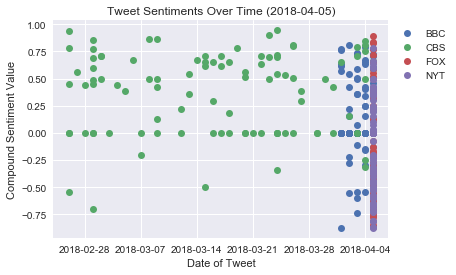

In [36]:
for org in NEWS_ORGS.keys():
    subset = tweet_data[tweet_data["organization"]==org]
    plt.plot(subset["date"], subset["compound"], 'o', label=org)
plt.xlabel("Date of Tweet")
plt.ylabel("Compound Sentiment Value")
plt.title(f"Tweet Sentiments Over Time ({date.today()})")
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig(f"{date.today()}-timeseries.png", bbox_inches="tight")
plt.show()

In [16]:
tweet_data.to_csv("4-5-18-1520_tweet_data.csv")

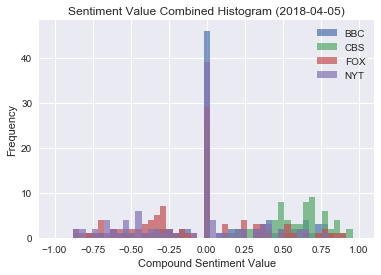

In [38]:
bins = np.linspace(-1.0, 1.0, 50)
for org in NEWS_ORGS.keys():
    subset = tweet_data[tweet_data["organization"]==org]
    plt.hist(subset["compound"], bins, alpha=0.7, label=org)
plt.legend()
plt.xlabel("Compound Sentiment Value")
plt.ylabel("Frequency")
plt.title(f"Sentiment Value Combined Histogram ({date.today()})")
plt.savefig(f"{date.today()}-histogram.png")
plt.show()

In [22]:
tweet_data[tweet_data["organization"]=="BBC"].describe()

,neg,neu,pos,compound
count,100.000000,100.000000,100.000000,100.000000
mean,0.036820,0.888800,0.074380,0.092903
std,0.081671,0.122069,0.108243,0.372813
min,0.000000,0.576000,0.000000,-0.875000
25%,0.000000,0.789000,0.000000,0.000000
50%,0.000000,0.905000,0.000000,0.000000
75%,0.000000,1.000000,0.138750,0.361200
max,0.333000,1.000000,0.371000,0.812200


In [23]:
tweet_data[tweet_data["organization"]=="CBS"].describe()

,neg,neu,pos,compound
count,100.000000,100.000000,100.000000,100.000000
mean,0.020860,0.827120,0.152000,0.362195
std,0.052303,0.134438,0.131051,0.380300
min,0.000000,0.462000,0.000000,-0.698100
25%,0.000000,0.747250,0.000000,0.000000
50%,0.000000,0.821500,0.150500,0.490550
75%,0.000000,1.000000,0.238000,0.675575
max,0.230000,1.000000,0.538000,0.945100


In [24]:
tweet_data[tweet_data["organization"]=="FOX"].describe()

,neg,neu,pos,compound
count,100.000000,100.000000,100.000000,100.000000
mean,0.097390,0.842250,0.060360,-0.078951
std,0.119867,0.131574,0.105857,0.412206
min,0.000000,0.509000,0.000000,-0.865800
25%,0.000000,0.737750,0.000000,-0.361200
50%,0.000000,0.855500,0.000000,0.000000
75%,0.172750,1.000000,0.110250,0.128000
max,0.416000,1.000000,0.465000,0.888500


In [25]:
tweet_data[tweet_data["organization"]=="NYT"].describe()

,neg,neu,pos,compound
count,100.000000,100.000000,100.000000,100.000000
mean,0.075600,0.878470,0.045910,-0.094217
std,0.107205,0.132251,0.080389,0.371639
min,0.000000,0.408000,0.000000,-0.872000
25%,0.000000,0.799250,0.000000,-0.411525
50%,0.000000,0.879500,0.000000,0.000000
75%,0.153000,1.000000,0.083750,0.025800
max,0.515000,1.000000,0.418000,0.778300


## Conclusions

It appears from the first figure that CBS tweets far less than the BBC, and they both tweet less than the NY Times and Fox News.  Both Fox News and the NY Times have all 100 most recent tweets appearing today, while CBS's 100th-most-recent tweet was over a month ago.

From the histogram, we can see that CBS, is generally more positive than the other news outlets.  There seems to be a spike around zero, especially for the BBC.  One might hope that that points to a lack of impassioned twitter rants on their part, but it could also be a difference in the language the VADER evaluates.

Both the NY Times and Fox News seem to be shifted towards the negative end of the spectrum (although the BBC actually has the overall "most negative" tweet).